<a href="https://colab.research.google.com/github/magda-r/nlp-covid19/blob/master/notebooks/nlp_covid19_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 - Tweets' Sentiment Analysis 

### Imports and loading data

In [2]:
import pandas as pd
import numpy as np
import itertools
import collections
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import warnings
sns.set_theme()
sns.diverging_palette(220, 20, as_cmap=True)

warnings.filterwarnings("ignore")
pd.set_option('mode.chained_assignment', None)

In [3]:
# # Setting up stopwords list
stopwords = set(STOPWORDS)
# excluding keywords used in query (collection words)
stopwords.update(['covid', 'covid19', 'coronavirus', 'corona', 'virus', 'pandemic', 'vaccine', 'vaccinated', 'lockdown', 'quarantine'])
# excluding a couple more irrelevant ones
stopwords.update(['', 'u', 's', 'm', 've', 't', 'don', 're', 'amp'])

In [4]:
df = pd.read_pickle('../data/covid19_tweets_cleaned_5000.pkl')
# df = pd.read_csv('../data/covid19_tweets_cleaned.csv', converters={'column_name': eval})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5000 non-null   int64 
 1   text          5000 non-null   object
 2   datetime      5000 non-null   object
 3   no_replies    5000 non-null   int64 
 4   no_retweets   5000 non-null   int64 
 5   no_likes      5000 non-null   int64 
 6   user          5000 non-null   object
 7   location      3767 non-null   object
 8   no_followers  5000 non-null   int64 
 9   sentiment     5000 non-null   object
 10  text_clean    5000 non-null   object
 11  text_stem     5000 non-null   object
 12  text_lem      5000 non-null   object
dtypes: int64(5), object(8)
memory usage: 507.9+ KB


In [6]:
df.head()

id                                               text  \
0  1356028686701477888  covid still exists and yall are so so close to...   
1  1293697993875623936  School districts plan for the most UNFEASABLE ...   
2  1253110981607079936  COVID-19 Omnibus (Emergency Measures) Bill 202...   
3  1378858911747411968  From the archives: Coming together when we’re ...   
4  1237528569640698112  YO Korean government has succeeded in developi...   

                    datetime  no_replies  no_retweets  no_likes  \
0  2021-01-31 23:56:47+00:00           0            0         0   
1  2020-08-12 23:56:52+00:00           0            0         0   
2  2020-04-22 23:58:34+00:00           0            0         0   
3  2021-04-04 23:55:57+00:00           0            0         1   
4  2020-03-10 23:59:37+00:00           1            5         3   

                                 user                   location  \
0                              diji 🎀                  Mark Tuan   
1  @Pechilvr @WarOnFibro #OwnYourData             North Carolina   
2                        Sean Mulcahy  Ballarat North, Australia   
3                Mum Muddling Through              Kent, England   
4                         miracassano                        NaN   

   no_followers sentiment                                         text_clean  \
0            43  negative  still exists and yall are so so close to mark ...   
1           935   neutral  school districts plan for the most unfeasable ...   
2          1828   neutral  omnibus  emergency measures  bill  introduced ...   
3         14712  positive  from the archives  coming together when we’re ...   
4          1231  positive  yo korean government has succeeded in developi...   

                                           text_stem  \
0  [still, exist, yall, close, mark, triumph, tri...   
1  [school, district, plan, unfeas, safe, plan, o...   
2  [omnibu, emerg, measur, bill, introduc, releas...   
3                 [archiv, come, togeth, far, apart]   
4  [yo, korean, govern, succeed, develop, antibod...   

                                            text_lem  
0  [still, exists, yall, close, mark, triumph, tr...  
1  [school, district, plan, unfeasable, safe, pla...  
2  [omnibus, emergency, measure, bill, introduced...  
3            [archive, coming, together, far, apart]  
4  [yo, korean, government, succeeded, developing...

In [7]:
# Original text
df['text'][22]

'The U.S. #airline industry and its pilots are essential to the distribution of a COVID-19 vaccine. Congress and government leaders must #ExtendPSP now to ensure critical infrastructure is in place to distribute a vaccine—American lives depend on it @SenRickScott.'

In [8]:
# Pre-processed text - stemmed
df['text_stem'][22]

['airlin',
 'industri',
 'pilot',
 'essenti',
 'distribut',
 'congress',
 'govern',
 'leader',
 'must',
 'extendpsp',
 'now',
 'ensur',
 'critic',
 'infrastructur',
 'place',
 'distribut',
 'american',
 'live',
 'depend',
 'senrickscott']

In [9]:
# Pre-processed text - lemmatized
df['text_lem'][22]

['airline',
 'industry',
 'pilot',
 'essential',
 'distribution',
 'congress',
 'government',
 'leader',
 'must',
 'extendpsp',
 'now',
 'ensure',
 'critical',
 'infrastructure',
 'place',
 'distribute',
 'american',
 'life',
 'depend',
 'senrickscott']

### Lexicon-based EDA 

#### Import lexicons  
A lexicon is a dictionary of words that computes the sentiment of a words by analyzing the "semantic orientation" of that word in a text. These codings are made by people, through crowdsorcing, etc.

- **Afinn**: gives the words a number between -5, 5, where -5 means that the words is very negative and 5 means that the words is very positive  
- **Bing**: gives the words an assignment of positive/negative sentiment  
- **NRC**: assigns the words one of the 8 primary emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and 2 sentiments (positive and negative)

In [10]:
afinn = pd.read_csv('../data/lexicons/Afinn.csv')
bing = pd.read_csv('../data/lexicons/Bing.csv')
nrc = pd.read_csv('../data/lexicons/NRC.csv')

In [68]:
print(len(afinn))
print(len(bing))
print(len(nrc))

2477
6786
8265


In [11]:
afinn.head()

word  value
0    abandon     -2
1  abandoned     -2
2   abandons     -2
3   abducted     -2
4  abduction     -2

In [12]:
bing.head()

word sentiment
0     2-faces  negative
1    abnormal  negative
2     abolish  negative
3  abominable  negative
4  abominably  negative

In [69]:
# filtering out potsitive/negative sentiments from NRC 
nrc = nrc[(nrc['sentiment'] != 'positive') & (nrc['sentiment'] != 'negative')]
nrc.columns = ['word', 'emotion']
nrc.head()

KeyError: 'sentiment'

#### Positive-Negative Wordcloud (redone with lemmatized tweets)

In [14]:
all_words = [item for sublist in df['text_lem'] for item in sublist]
counts = collections.Counter(all_words)
top_counts = pd.DataFrame(counts.most_common(16), columns=['word', 'count'])

Text(0.5, 1.0, '15 most frequent words')

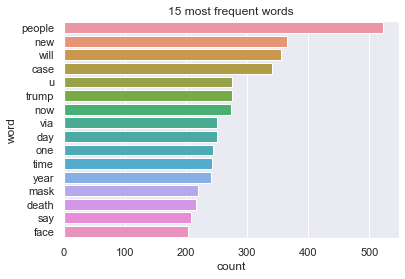

In [15]:
sns.barplot(x=top_counts['count'], y=top_counts['word']).set_title('15 most frequent words')

In [16]:
# join with sentiments from lexicons 
count_df = pd.DataFrame({'word': counts.keys(), 'count': counts.values()})
count_df = count_df.merge(afinn, how='left', on='word')
count_df = count_df.merge(bing, how='left', on='word')
count_df = count_df.merge(nrc, how='left', on='word')
count_df.head(10)

word  count  value sentiment       emotion
0     still    151    NaN       NaN           NaN
1    exists      3    NaN       NaN           NaN
2      yall     13    NaN       NaN           NaN
3     close     38    NaN       NaN           NaN
4      mark     13    NaN       NaN           NaN
5   triumph     10    4.0  positive  anticipation
6   triumph     10    4.0  positive           joy
7    school    120    NaN       NaN         trust
8  district     12    NaN       NaN           NaN
9      plan     73    NaN       NaN  anticipation

In [17]:
pos_words = count_df[count_df['sentiment'] == 'positive']['word'].drop_duplicates().tolist()
neg_words = count_df[count_df['sentiment'] == 'negative']['word'].drop_duplicates().tolist()

In [64]:
def filter_sentiment(text, words_to_filter): # veeery slow way
    return [word for word in text if any(n in word for n in words_to_filter)]

# def filter_sentiment(text, words_to_filter):
#     text_s = "".join([word for word in text if word in words_to_filter]) 
#     return text_s

pos_df = df['text_stem'].apply(lambda x: filter_sentiment(x, pos_words))
neg_df = df['text_stem'].apply(lambda x: filter_sentiment(x, neg_words))

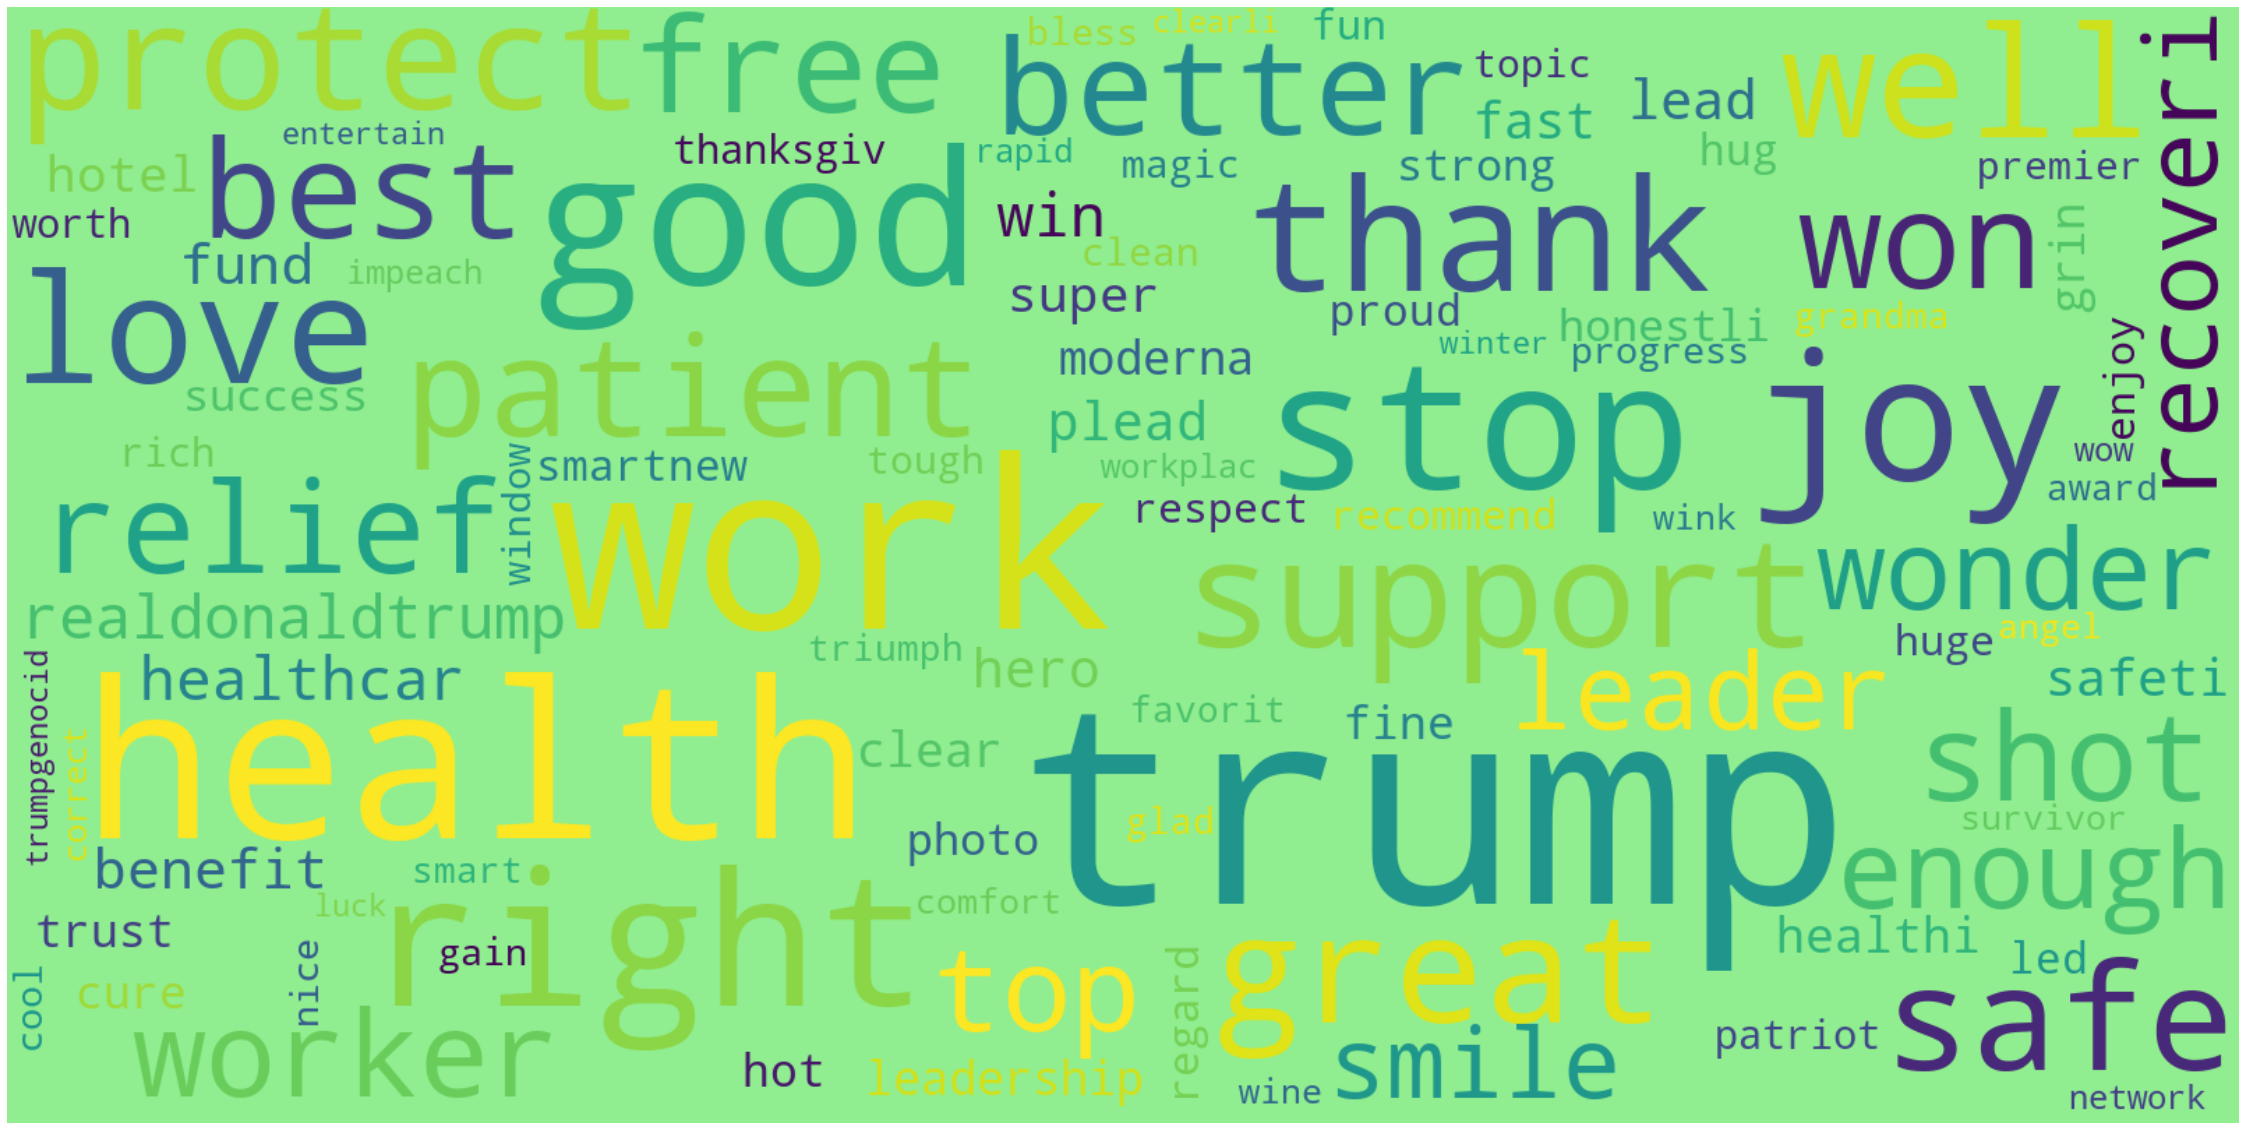

In [65]:
# Positive
string_pos = pos_df.apply(lambda x: " ".join(x))
string_pos = pd.Series(string_pos).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='lightgreen').generate_from_text(string_pos)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

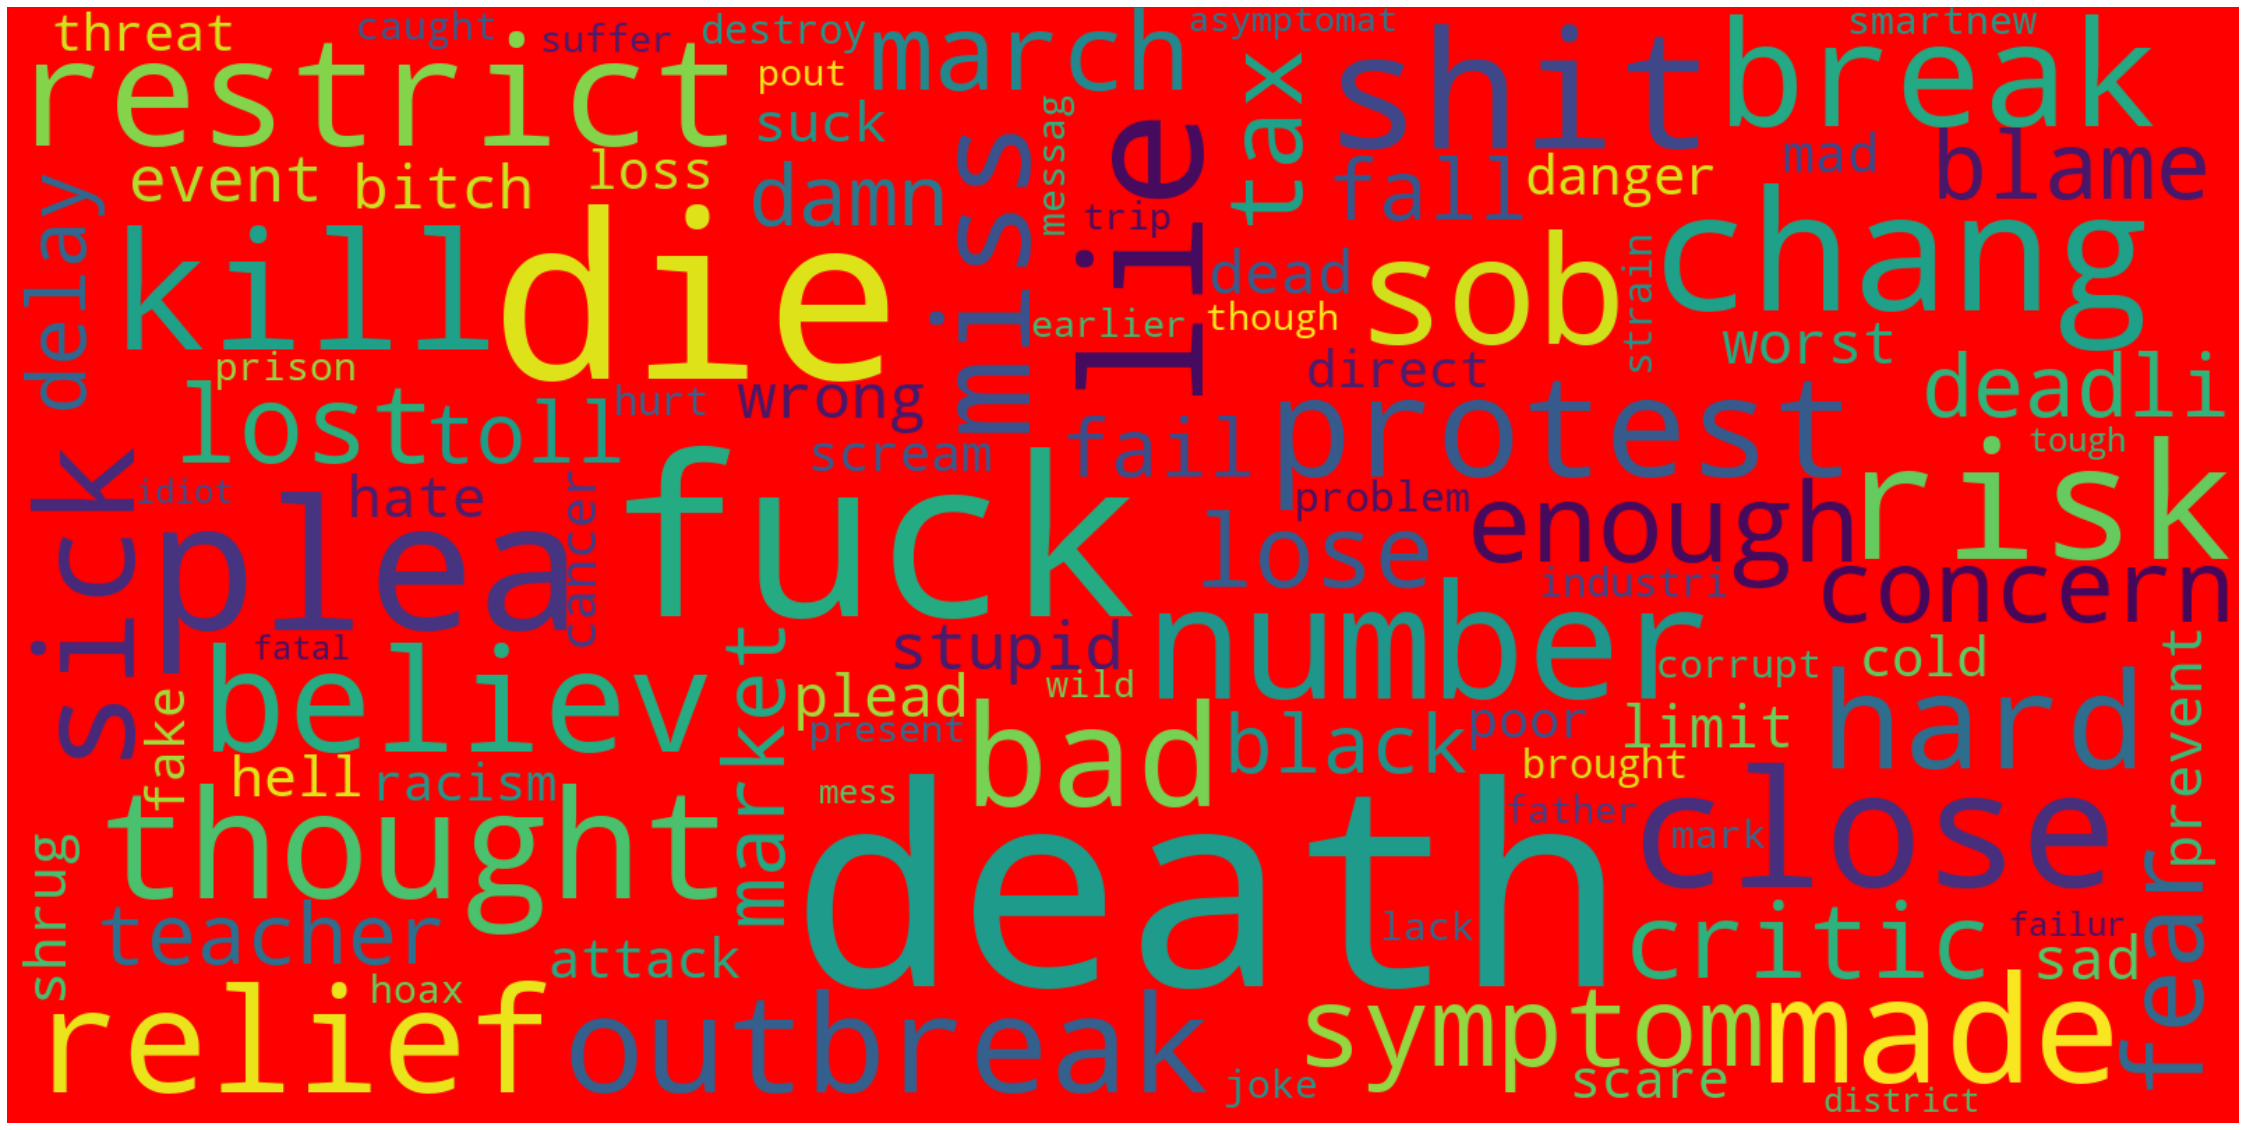

In [66]:
# Negative
string_neg = neg_df.apply(lambda x: " ".join(x))
string_neg = pd.Series(string_neg).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, stopwords=stopwords, height=800, max_font_size=200, max_words=100, collocations=False, background_color='red').generate_from_text(string_neg)
plt.figure(figsize=(40,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Primary Emotions Analysis

In [57]:
# emotions taken from NRC lexicon - for multiple matches take first (temporary solution)
sentiment_df = count_df[['count', 'emocja']].dropna()
sentiment_df = sentiment_df.groupby('emocja').first().reset_index()
sentiment_df = sentiment_df.sort_values('count', ascending=False)

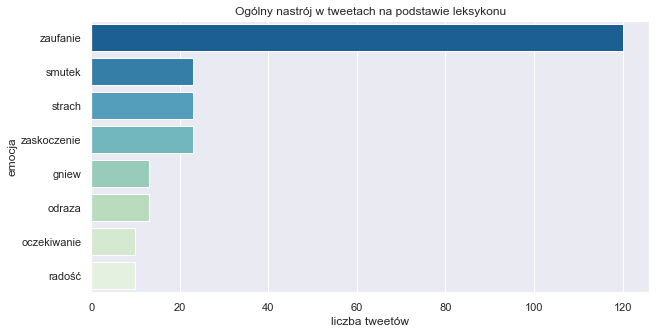

In [58]:
plt.figure(figsize=(10,5))
fig = sns.barplot(x=sentiment_df['count'], y=sentiment_df['emocja'], palette='GnBu_r')
fig.set(xlabel='liczba tweetów', ylabel='emocja', title='Ogólny nastrój w tweetach na podstawie leksykonu')
plt.show()

#### Emotions Split by Words

In [23]:
emotions_df = count_df[['word', 'count', 'emotion']].dropna()
emotions_df = emotions_df.groupby(['word', 'count']).first().reset_index()
emotions_df = emotions_df.sort_values('count', ascending=False)
emotions_df = emotions_df.groupby('emotion').head(10).reset_index(drop=True)

In [36]:
emotions_df = emotions_df.rename(columns={'emotion': 'emocja'})
emotions_df["emocja"].replace({"fear": "strach", "surprise": "zaskoczenie", "anticipation": "oczekiwanie", "anger": "gniew",\
    "trust": "zaufanie", "joy": "radość", "sadness": "smutek", "disgust": "odraza"}, inplace=True)

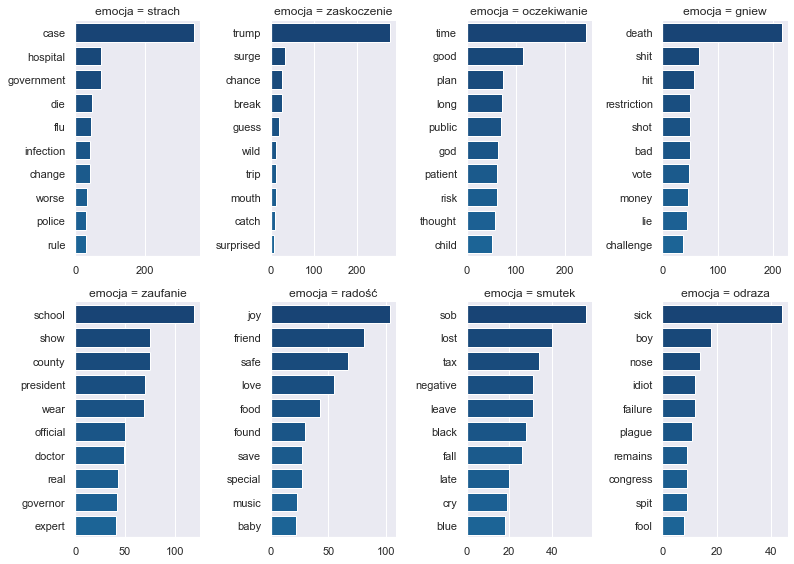

In [61]:
fig = sns.catplot(x="count", y="word", col="emocja",
            data=emotions_df, kind="bar",
            height=4, aspect=.7, col_wrap=4, 
            sharex=False, sharey=False, palette='GnBu_r')

fig.set(xlabel='', ylabel='')
plt.show()

#### Sentiment Split by Words

In [48]:
sentiment_df = count_df[['word', 'count', 'sentiment']].dropna()
sentiment_df = sentiment_df.groupby(['word', 'count']).first().reset_index()
sentiment_df = sentiment_df.sort_values('count', ascending=False)
sentiment_df = sentiment_df.groupby('sentiment').head(10).reset_index(drop=True)

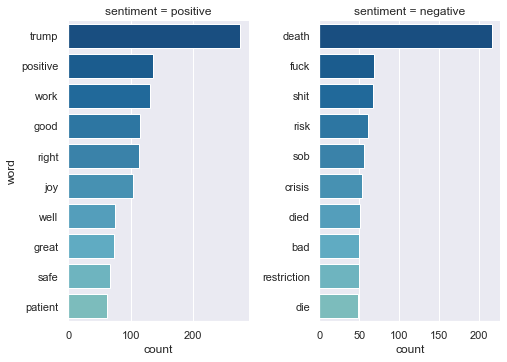

In [49]:
s = sns.catplot(x="count", y="word", col="sentiment",
            data=sentiment_df, kind="bar",
            height=5, aspect=.7, col_wrap=4, 
            sharex=False, sharey=False, color=None, palette='GnBu_r')

#### Sentiment Distribution

In [51]:
value_df = count_df[['word', 'count', 'value']].drop_duplicates().dropna()
value_df = value_df.sort_values('count', ascending=False)#.reset_index(drop=True)
value_df = value_df.groupby('value').sum('count').reset_index()

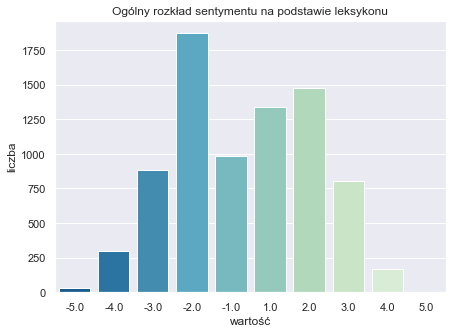

In [54]:
plt.figure(figsize=(7,5))
fig = sns.barplot(x=value_df['value'], y=value_df['count'], palette='GnBu_r')
fig.set(xlabel='wartość', ylabel='liczba', title='Ogólny rozkład sentymentu na podstawie leksykonu')
plt.show()

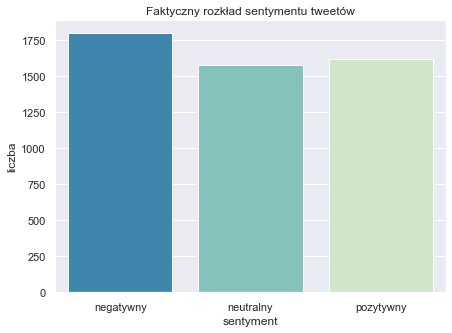

In [79]:
plt.figure(figsize=(7,5))
df_sent_actual = df[['sentiment', 'id']].groupby('sentiment').count().reset_index()
df_sent_actual["sentiment"].replace({"negative": "negatywny", "neutral": "neutralny", "positive": "pozytywny"}, inplace=True)
fig = sns.barplot(x=df_sent_actual['sentiment'], y=df_sent_actual['id'], palette='GnBu_r')
fig.set(xlabel='sentyment', ylabel='liczba', title='Faktyczny rozkład sentymentu tweetów')
plt.show()

### Predictive modelling

#### Dataset preparation

In [90]:
# train test split for rule based
X_text = df['text_clean'].values  
y = df['sentiment'].values

In [91]:
y

array(['negative', 'neutral', 'neutral', ..., 'negative', 'neutral',
       'neutral'], dtype=object)

In [92]:
from sklearn.model_selection import train_test_split  
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

#### Rule-based algorithms

Topic-specific phrases and words adjustmens
- positive
- negative
- trump
- tf
- gtfo
- hoe

##### TextBlob

In [93]:
from textblob import TextBlob

def textblob_compound(text, threshold=0.05):
    blob = TextBlob(text)
    score = blob.sentiment.polarity
    
    if score <= -threshold: return 'negative'
    elif score >= threshold: return 'positive'
    else: return 'neutral'

In [94]:
y_pred_textblob = pd.DataFrame(X_test_text)[0].apply(lambda x: textblob_compound(x))
y_pred_textblob.head()

0     neutral
1    positive
2     neutral
3    positive
4    negative
Name: 0, dtype: object

##### VADER

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).  

positive sentiment : (compound score >= 0.05)   
neutral sentiment : (compound score > -0.05) and (compound score < 0.05)   
negative sentiment : (compound score <= -0.05)  

In [95]:
def vader_compound(text, threshold=0.05):
    # Calling the polarity_scores method on sid and passing in the text
    # outputs a dictionary with negative, neutral, positive, and compound scores for the input text
    scores = SIA.polarity_scores(text)

    # get compound score
    score = scores['compound']
     
    # translate the score into the correcponding input according to the threshold
    if score <= -threshold: return 'negative'
    elif score >= threshold: return 'positive'
    else: return 'neutral'

    #return sid.polarity_scores(text)['compound']


In [96]:
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

new_words = {
    'positive': 0.0,
    'negative': 0.0,
    'trump': 0.0,
    'gtfo': -2.0,
    'taking away': -2.0,
    'aggy': -2.0,
    'hoe': -2.0,
    'increase': -1.0,
    'bs': -2.0,
    
}
SIA = SentimentIntensityAnalyzer()

SIA.lexicon.update(new_words)

y_pred_vader = pd.DataFrame(X_test_text)[0].apply(lambda x: vader_compound(x))
y_pred_vader.head()

0     neutral
1    positive
2     neutral
3     neutral
4    positive
Name: 0, dtype: object

### Vectorization

#### Bag of Words

In [97]:
from nltk.tokenize import casual_tokenize
from collections import Counter

bag_of_words = []

for text in df.text_clean:
    bag_of_words.append(Counter(casual_tokenize(text)))

df_bows = pd.DataFrame.from_records(bag_of_words)
df_bows = df_bows.fillna(0).astype(int)

In [98]:
df_bows.shape

(5000, 13900)

In [99]:
df_bows.head()

still  exists  and  yall  are  so  close  to  mark  triumph  ...  forth  \
0      1       1    1     1    1   2      1   1     1        7  ...      0   
1      0       0    0     0    0   0      0   0     0        0  ...      0   
2      0       0    1     0    0   0      0   0     0        0  ...      0   
3      0       0    0     0    0   0      0   0     0        0  ...      0   
4      0       0    0     0    0   0      0   0     0        0  ...      0   

   amplify  emotionally  idek  pats  peruvian  billionairs  dominique  \
0        0            0     0     0         0            0          0   
1        0            0     0     0         0            0          0   
2        0            0     0     0         0            0          0   
3        0            0     0     0         0            0          0   
4        0            0     0     0         0            0          0   

   requires  dakota  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  

[5 rows x 13900 columns]

#### TF-IDF

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
X_train = vectorizer.fit_transform(pd.DataFrame(X_train_text)[0])
X_test = vectorizer.transform(pd.DataFrame(X_test_text)[0])

### Machine Learning algorithms

In [ ]:
# # Train test split for ML
# X = df_bows.values
# y = df['sentiment'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### jakis shit

In [29]:

# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from time import time
# import numpy as np

# def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
#     if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
#         null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
#     else:
#         null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
#     t0 = time()
#     sentiment_fit = pipeline.fit(X_train, y_train)
#     y_pred = sentiment_fit.predict(x_test)
#     train_test_time = time() - t0
#     accuracy = accuracy_score(y_test, y_pred)
#     print("null accuracy: {0:.2f}%".format(null_accuracy*100))
#     print("accuracy score: {0:.2f}%".format(accuracy*100))
#     if accuracy > null_accuracy:
#         print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
#     elif accuracy == null_accuracy:
#         print("model has the same accuracy with the null accuracy")
#     else:
#         print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
#     print("train and test time: {0:.2f}s".format(train_test_time))
#     print("-"*80)
#     return accuracy, train_test_time

# cvec = CountVectorizer()
# lr = LogisticRegression()
# n_features = np.arange(10000,100001,10000)

# def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
#     result = []
#     print (classifier)
#     print ("\n")
#     for n in n_features:
#         vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
#         checker_pipeline = Pipeline([
#             ('vectorizer', vectorizer),
#             ('classifier', classifier)
#         ])
#         print ("Validation result for {} features".format(n))
#         nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, pd.DataFrame(X_train), pd.DataFrame(y_train), pd.DataFrame(X_test), pd.DataFrame(y_test))
#         result.append((n,nfeature_accuracy,tt_time))
#     return result

# from sklearn.feature_extraction.text import TfidfVectorizer
# tvec = TfidfVectorizer()

# feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
# feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
# feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))


# nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
# nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
# nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
# plt.figure(figsize=(8,6))
# plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
# plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
# plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
# plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
# plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
# plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
# plt.title("N-gram(1~3) test result : Accuracy")
# plt.xlabel("Number of features")
# plt.ylabel("Validation set accuracy")
# plt.legend()

In [30]:
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.naive_bayes import MultinomialNB, BernoulliNB
# from sklearn.linear_model import RidgeClassifier
# from sklearn.linear_model import PassiveAggressiveClassifier
# from sklearn.linear_model import Perceptron
# from sklearn.neighbors import NearestCentroid
# from sklearn.feature_selection import SelectFromModel

# names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
#          "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
# classifiers = [
#     LogisticRegression(),
#     LinearSVC(),
#     Pipeline([
#   ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
#   ('classification', LinearSVC(penalty="l2"))]),
#     MultinomialNB(),
#     BernoulliNB(),
#     RidgeClassifier(),
#     AdaBoostClassifier(),
#     Perceptron(),
#     PassiveAggressiveClassifier(),
#     NearestCentroid()
#     ]
# zipped_clf = zip(names,classifiers)

# tvec = TfidfVectorizer()
# def classifier_comparator(vectorizer=tvec, n_features=100, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
#     result = []
#     vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
#     for n,c in classifier:
#         checker_pipeline = Pipeline([
#             ('vectorizer', vectorizer),
#             ('classifier', c)
#         ])
#         print("Validation result for {}".format(n))
#         print(c)
#         clf_accuracy,tt_time = accuracy_summary(checker_pipeline, pd.DataFrame(X_train), pd.DataFrame(y_train), pd.DataFrame(X_test), pd.DataFrame(y_test))
#         result.append((n,clf_accuracy,tt_time))
#     return result

# trigram_result = classifier_comparator(n_features=100,ngram_range=(1,3))

#### Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)  
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

#### Naive Bayes

In [102]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

#### SVC

In [103]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

### Evaluation of the results

In [ ]:
np.set_printoptions(precision=2)
target_names = ['negative', 'neutral', 'positive']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

#### Rule-based algorithms

In [118]:
# textblob
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred_textblob))

              precision    recall  f1-score   support

    negative       0.70      0.36      0.48       360
     neutral       0.42      0.53      0.47       316
    positive       0.50      0.65      0.56       324

    accuracy                           0.51      1000
   macro avg       0.54      0.51      0.50      1000
weighted avg       0.55      0.51      0.50      1000



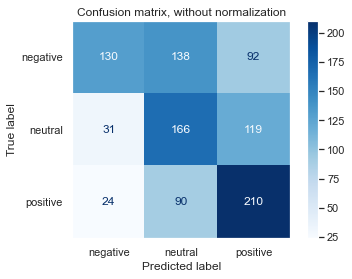

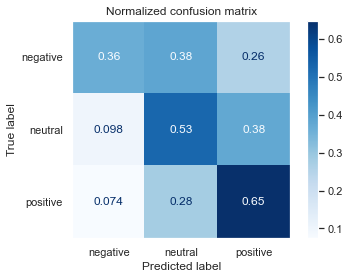

In [137]:
from sklearn.metrics import ConfusionMatrixDisplay
# plt.subplot(1, 2, 1)
for title, normalize in titles_options:
    
    cm = confusion_matrix(y_test, y_pred_textblob, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    plt.grid(False)
    # plt.tight_layout()


# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# # fig.suptitle('Distribution of subscribtion to term deposit - campaign and control')
# sns.histplot(df['Price'], ax=ax1)
# sns.histplot(np.log(df['Price']), ax=ax2)

plt.show()

In [143]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True,
                                 random_state=42))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

NameError: name 'X' is not defined

In [144]:
y

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=int32)

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [105]:
# vader
print(classification_report(y_test, y_pred_vader))

[[301  24  35]
 [ 37 227  52]
 [  9  11 304]]
              precision    recall  f1-score   support

    negative       0.87      0.84      0.85       360
     neutral       0.87      0.72      0.79       316
    positive       0.78      0.94      0.85       324

    accuracy                           0.83      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.83      0.83      1000



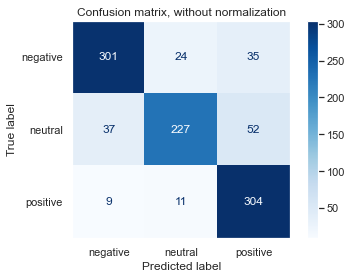

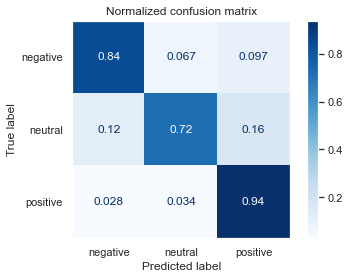

In [126]:
for title, normalize in titles_options:
    cm = confusion_matrix(y_test, y_pred_vader, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    plt.grid(False)

plt.show()

#### Machine Learning algorithms

In [106]:
# logistic reggresion
print(classification_report(y_test, y_pred_lr, target_names=target_names))

[[204  91  65]
 [ 80 173  63]
 [ 66  69 189]]
              precision    recall  f1-score   support

    negative       0.58      0.57      0.57       360
     neutral       0.52      0.55      0.53       316
    positive       0.60      0.58      0.59       324

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



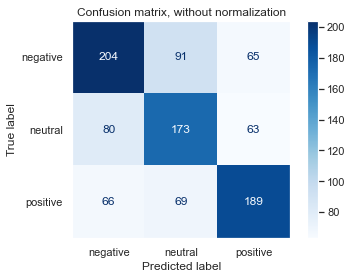

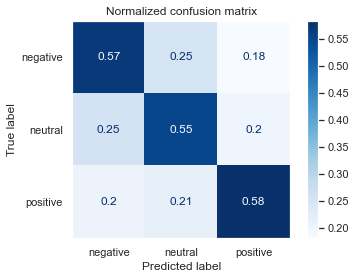

In [127]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.grid(False)

plt.show()

In [ ]:
# naive bayes
print(classification_report(y_test, y_pred_nb, target_names=target_names))

[[236  74  50]
 [124 125  67]
 [ 81  45 198]]
              precision    recall  f1-score   support

    negative       0.54      0.66      0.59       360
     neutral       0.51      0.40      0.45       316
    positive       0.63      0.61      0.62       324

    accuracy                           0.56      1000
   macro avg       0.56      0.55      0.55      1000
weighted avg       0.56      0.56      0.55      1000



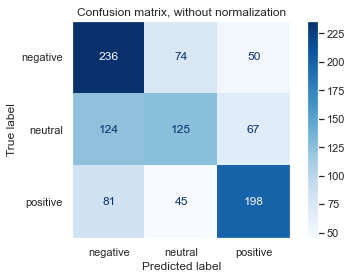

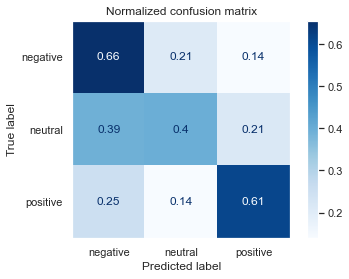

In [128]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(nb, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.grid(False)

plt.show()

In [ ]:
# svc
print(classification_report(y_test, y_pred_svc, target_names=target_names))

[[205  89  66]
 [ 90 175  51]
 [ 67  67 190]]
              precision    recall  f1-score   support

    negative       0.57      0.57      0.57       360
     neutral       0.53      0.55      0.54       316
    positive       0.62      0.59      0.60       324

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000



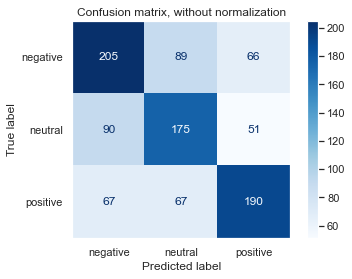

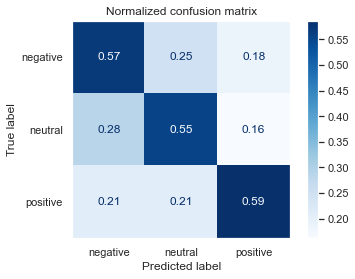

In [129]:
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.grid(False)

plt.show()